# House Price Prediction Model

For this project, I will be using machine learning to predict the sale price of houses.

## Import dependencies

In [1]:
import pandas as pd                                           # Data manipulation.
import numpy as np                                            # Work with numbers.

import matplotlib.pyplot as plt                               # Graphing capabilities.
import seaborn as sns                                         # More plots than plt and improved visuals.

from sklearn.pipeline import Pipeline                         # Bundle together preprocessing and modeling steps for later ease of use.
from sklearn.impute import SimpleImputer                      # Pick how to fill missing data.
from sklearn.preprocessing import OneHotEncoder               # Encode nominal data by giving each value its own column of 0s and 1s.
from sklearn.preprocessing import OrdinalEncoder              # Encode ordinal data by assigning a number to each possible value.
from sklearn.compose import ColumnTransformer                 # Apply multiple transformations to columns all at once.
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import mutual_info_regression  # A metric to pick the best features.
from sklearn.cluster import KMeans                            # An unsupervised model that clusters similar features together.
import xgboost as xgb                                         # A supervised model with gradient boosting.
from sklearn.model_selection import GridSearchCV              # Cross validate models using grid search.

# Display plots directly below code.
%matplotlib inline

## Load and display dataset

In [4]:
# Make a DataFrame from the training data, indexed by ID.
training_data = pd.read_csv("train.csv", index_col="Id")

# Display the first houses in the training dataset.
training_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Preprocessing
Before we can get started making our model, let's organize our data. To do this, we'll break the data into three groups: Nominal, Ordinal, and Numeric.

In [5]:
# For the nominal columns, make a list of all features with unordered categories.
nominal_cols = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# For the ordinal columns, create a dict where key:value is feature_name:[ordered possibilities].
# Any missing values will be set to None, so we will add None to each list of possible values.
ordinal_cols = {
    "LotShape": ["None"] + ["Reg", "IR1", "IR2", "IR3"],
    "Utilities": ["None"] + ["NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["None"] + ["Sev", "Mod", "Gtl"],
    "OverallQual": ["None"] + [num for num in range(1, 11)],
    "OverallCond": ["None"] + [num for num in range(1, 11)],
    "ExterQual": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["None"] + ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["None"] + ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["None"] + ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "CentralAir": ["None"] + ["N", "Y"],
    "Electrical": ["None"] + ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "KitchenQual": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["None"] + ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "FireplaceQu": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["None"] + ["Unf", "RFn", "Fin"],
    "GarageQual": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["None"] + ["N", "P", "Y"],
    "PoolQC": ["None"] + ["Po", "Fa", "TA", "Gd", "Ex"],
    "Fence": ["None"] + ["MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# Get the names of the features in each group.
all_nominal_names = nominal_cols
all_ordinal_names = ordinal_col_names = list(ordinal_cols.keys())

# Combine those together to get a list of all categorical feature's names.
all_categorical_names = all_nominal_names + all_ordinal_names

all_numeric_names = [column_name for column_name in training_data.columns if column_name not in all_categorical_names and column_name != "SalePrice"]

## Preprocessing
Before we can work with the data, we must preprocess it so that it is in a form easier for our model to use. The preprocessing step will include transforming all categorical data into a numeric form, as well as imputing and scaling if necessary.

### Observing Missing Data
The first step of preprocessing is making sure there are no values missing in the data. To determine whether this step is necessary, let's take a look at our data to see if any values are missing.

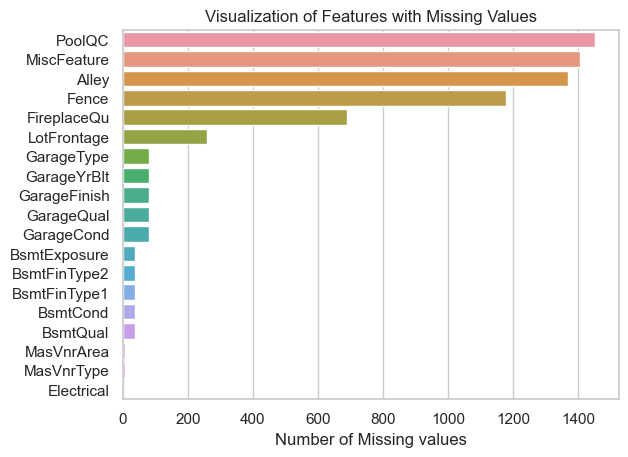

In [6]:
# Create a Series of the number of nulls per column, and remove any with 0 nulls.
nulls_per_column = training_data.isnull().sum()
null_cols = nulls_per_column[nulls_per_column != 0]

# Sort in descending order and plot out result.
null_cols.sort_values(inplace=True, ascending=False)
sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(y=null_cols.index, x=null_cols)

plt.title("Visualization of Features with Missing Values")
plt.xlabel("Number of Missing values")
plt.show()

As we can see, there are many features with missing values in our data. While a simple fix would be to remove all columns with missing values from our list of predictors, we may end up losing very important information that way. To prevent that possibility, we will instead be using imputation. Imputation replaces missing values in the data with a value.


We can examine this more closely to see which groups (Ordinal, Nominal, or Numeric) need to have values imputed. At the top of our chart is PoolQC, which stands for Pool Quality. Since the quality of a pool is rated from Fair to Excellent, this is an ordinal column. Below that we see MiscFeature, which represents the miscellaneous features a house can have. This has a list of options as well, but none are inherently better than the others, so it is clear that this is a nominal column. Further down we see LotFrontage which represents the linear feet of street connected to property and is a numeric column.

From this analysis, we can see that we must use imputation on each of the three feature types.

### Determining Scaler
Now that we have seen which data to impute, we can take a look at our data to determine whether to scale our features using StandardScaler or RobustScaler. The StandardScaler works best when the data has a normal distribution, while the RobustScaler is much better to use for data with outliers. 

I expect to find that the data has outliers, as my outside knowledge tells me that some people buy houses that are much larger than the average house. However, rather than making that assumption, we can use visualization to check its accuracy for ourselves.

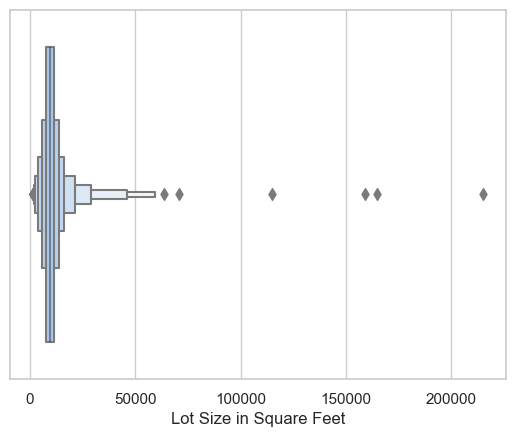

In [7]:
# Check for outliers in LotArea.
sns.boxenplot(x=training_data.LotArea)
plt.xlabel("Lot Size in Square Feet")
plt.show()

This boxenplot shows that most houses have an area less than 50,000 square feet. The diamonds we can see symbolize the outliers. From this chart, it seems my hypothesis was correct, so we will use RobustScaler on the numeric columns of this data.

### Create Preprocessing Pipeline
For this stage, we will use pipelines to keep our process organized and easy to use. We'll start off with some basic transformations on the data that will be sufficient until we figure out which features to select. Later on, once we have decided the features we will be using for our model, we can pick transformations that are more fitting for the features they are applied to.

In [9]:
# For ordinal features, convert all ordered values into numbers, where missing values are assigned to 0.
ordinal_starter_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ordinal", OrdinalEncoder(categories=list(ordinal_cols.values())))
])

# For nominal features, we will eventually use one-hot encoding.
# However, until we decide on which columns to focus on, we will use a more simple OrdinalEncoder to assign numbers to each value.
nominal_starter_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ordinal", OrdinalEncoder())
])

# For numeric features, we do not need to do any encoding. We will simply fill missing values with their column mean.
numeric_starter_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("robust_scaler", RobustScaler())
])

# Now we will apply these transformers to their respective columns and bundle together the results.
starter_preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", ordinal_starter_transformer, all_ordinal_names),
        ("nominal", nominal_starter_transformer, all_nominal_names),
        ("numeric", numeric_starter_transformer, all_numeric_names)
    ],
    verbose_feature_names_out=False    # Prevent the feature names from changing when accessed later.
)

## Feature Selection
Now that we have our preprocessing pipeline ready for use, we can begin with the feature selection process. This dataset contains many features, so it can be overwhelming to choose which of these features to use for our model. To help narrow it down, we will use mutual information to check how closely each feature relates to the target.

In [10]:
# Before we narrow down on features, we will use starting_X, which will contain all possible features.
starting_X = training_data.copy()

# Set y to our target feature. Since this never needs to change, we don't need to create a "starting_y".
y = starting_X.pop("SalePrice")

# Apply our preprocesser to the data.
preprocessed_X = starter_preprocessor.fit_transform(starting_X)

# Get the MI scores of each feature and place them into a DataFrame.
mi_scores = mutual_info_regression(preprocessed_X, y, random_state=1)
mi_scores = pd.DataFrame({"Feature": starting_X.columns, "MI_Score": mi_scores})

Now that the MI scores have been calculated, let's find out which features tell us the most about our target. We can do this by checking the MI scores of the top 10 highest scoring features.

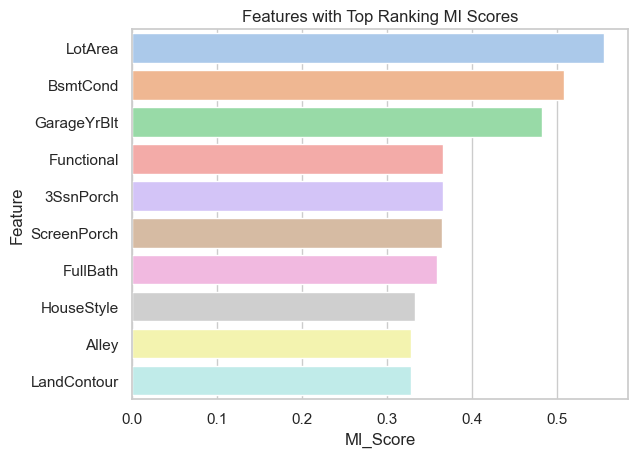

In [11]:
# Graph the features with the highest MI scores.
top_ten = mi_scores.sort_values(by="MI_Score", ascending=False).head(10)
sns.barplot(y=top_ten.Feature, x=top_ten.MI_Score)
plt.title("Features with Top Ranking MI Scores")
plt.show()

Now we have seen our highest ranked features. While this is interesting to know, we can now make greater use of these scores by using them to determine which columns (if any) we should drop from our list of predictors.

In [12]:
# Display lowest ranking features.
mi_scores.sort_values(by="MI_Score").head(10)

,Feature,MI_Score
1,MSZoning,0.000000
2,LotFrontage,0.000000
76,YrSold,0.000000
75,MoSold,0.000000
32,BsmtFinType1,0.000000
26,ExterQual,0.000000
73,MiscFeature,0.000000
22,Exterior1st,0.000000
77,SaleType,0.000000
41,Electrical,0.002265


## Data Cleaning
We can see that several features have an MI score of 0, which shows us that those features are independent from the sale price of houses. We will clean our data by removing these columns from our list of features.

In [13]:
# Get list of all features with MI scores > 0.
selected_features = mi_scores[mi_scores.MI_Score != 0].Feature.tolist()

# Clean data by setting X to only contain the columns we will use to make predictions.
X = training_data[selected_features].copy()

# Now that we are only looking at a subset of the data, we must group the features by type again.
selected_nominal = [col_name for col_name in selected_features if col_name in all_nominal_names]
selected_ordinal = [col_name for col_name in selected_features if col_name in all_ordinal_names]
selected_numeric = [col_name for col_name in selected_features if col_name in all_numeric_names]

Now we will remake our pipelines for the clean data.

In [17]:
ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ordinal", OrdinalEncoder(categories=[ordinal_cols[feature] for feature in selected_ordinal]))
])

# We can now change our nominal transformer to use one-hot encoding.
# This will give each nominal value its own binary column.
nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("robust_scaler", RobustScaler())
])

# Apply the transformers to their respective columns.
preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", ordinal_transformer, selected_ordinal),
        ("nominal", nominal_transformer, selected_nominal),
        ("numeric", numeric_transformer, selected_numeric)
    ],
)

## Feature Engineering
We will now use K-Means Clustering, an unsupervised model which can find relationships between our predictors. We will then create a new feature containing the relationships (or clusters) that were found.

In [22]:
# Apply our preprocesser to the data.
preprocessed_X = preprocessor.fit_transform(X)

# Assign each house to one of 20 clusers.
# clusterer = KMeans(n_clusters=20, n_init="auto", random_state=1)
clusterer = KMeans(n_clusters=20, n_init=10, random_state=1)
X["Cluster"] = clusterer.fit_predict(preprocessed_X)

I will now select five columns at random to visualize so that we may observe the clusters within the chosen features.

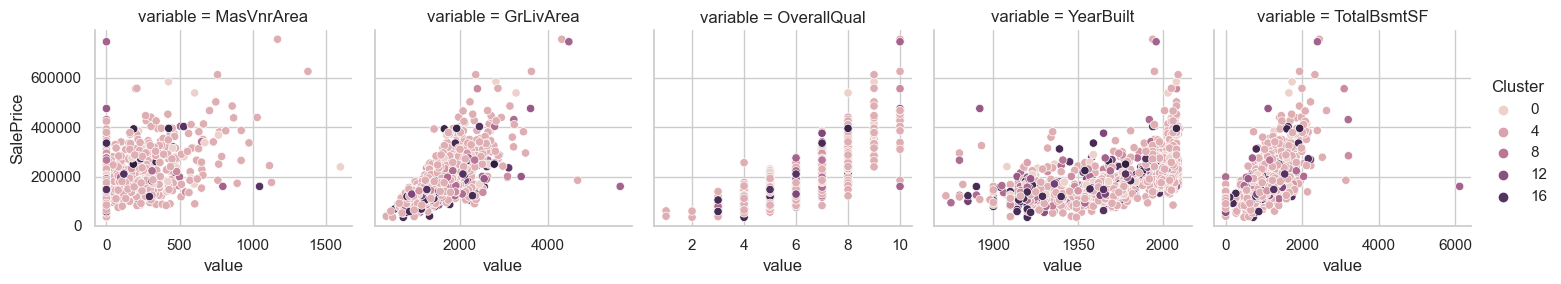

In [23]:
# Five columns to visualize, selected at random.
columns_to_graph = ["MasVnrArea", "GrLivArea", "OverallQual", "YearBuilt", "TotalBsmtSF"]

sns.relplot(
    data=pd.concat([y, X], axis=1).melt(   # Combine target with predictors and reshape from wide to long format.
        id_vars=["SalePrice", "Cluster"],  # Keep SalePrice and Cluster in their own column.
        value_vars=columns_to_graph),      # The column 'variable' contains the feature names.
    x="value",                             # After melting, "value" in the column containing the value for each SalePrice/Cluster/Feature pair.
    y="SalePrice", 
    hue="Cluster",                         # Color them based on their cluster.
    col="variable",                        # What to plot on each facet. Remember that 'variable' are the feature names after the melt/
    height=3, 
    facet_kws={'sharex': False},           # Give them each their own x-axis.
    col_wrap=5,                            # Show 5 on each line.
)

plt.show()

## Model Creation
Now that we have selected our features grouped them together, we are ready for our model. We will be using XGBRegressor, a supervised model with gradient boosting.

To help us determine the best hyperparameters for our model, we will be trying out several combinations to find which hyperparameters perform best with our data. We will do this using GridSearchCV, a tool which tries different combinations of hyperparameters and uses cross validation to compare them against multiple subsets of the training data. From this, we can discover which model preforms best on average.

In [26]:
# Create a pipeline to preprocess the data and apply the model to it.
XGB_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),                      # Preprocess the data.
        ("XGB_model", xgb.XGBRegressor(random_state=1))    # A supervised model which uses gradient boosting.
    ])

# The parameters to grid search.
XGB_model_params = {
    'XGB_model__n_estimators': [400, 500],                 # Find best number of models to include.
    'XGB_model__max_depth': [2, 3, 4],                     # How deep should each tree go?
    'XGB_model__learning_rate': [0.1],                     # Change how much each tree added to the model helps.
}

XGB_model = GridSearchCV(XGB_pipeline, XGB_model_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_log_error')

# Train our model on the data.
XGB_model.fit(X, y)

# The Kaggle House Prices competition grades using Root-Mean-Squared-Log-Error, 
# So I will get the root of the negative of my result.
score = np.sqrt(-1 * XGB_model.best_score_)

# See the parameters chosen by the grid search.
print("Best parameters: " + str(XGB_model.best_params_))

# Check score. The closer to 0, the better.
print("Root mean squared error score: " + str(score))

Best parameters: {'XGB_model__learning_rate': 0.1, 'XGB_model__max_depth': 3, 'XGB_model__n_estimators': 500}
Root mean squared error score: 0.12638173165554772


# Make Predictions
Now that we have created our machine learning model, we are ready to apply the model to a new set of data to make predictions on sale prices we have never seen.

In [27]:
# Make a DataFrame from the testing data, indexed by ID.
path = "test.csv"
X_test = pd.read_csv(path, index_col="Id")

# Make predictions on the new data.
predictions = XGB_model.predict(X_test)

# Output the results as a CSV file for submission!
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)